In [24]:
# work in progress

In [25]:
# Bayesian adaptive design / sequential Bayesian design to:
#   1. update belief about the heat pain threshold and
#   2. decide on the temperature for the next trial.

# TODO
# add other steps of calib_heat.m
# make it modular and add it to psychopy

In [26]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Step 1: Define a prior probability distribution for the heat pain threshold
min_temperature = 31
max_temperature = 45
mean_temperature = (min_temperature + max_temperature) / 2
std_temperature = 3.5
likelihood_std_temperature = 1

x = np.arange(min_temperature, max_temperature+0.1, 0.1) # temperature range
prior = stats.norm.pdf(x, loc=mean_temperature, scale=std_temperature)
prior /= np.sum(prior)  # normalize to make it a valid probability distribution

# Step 2: Start the experiment with a predetermined temperature
current_temperature = np.round(x[np.argmax(prior)],2)

# Store distributions and temperatures for each trial
priors = []
likelihoods = []
posteriors = []
temperatures = [current_temperature]

# Step 3-6: Repeat for each trial
trials = 8

for trial in range(trials):
    # Collect the subject's response
    response = input(f'Is {current_temperature} degrees Celsius painful? (y/n) ')

    # Define a likelihood function based on the response
    if response == 'y':
        likelihood = 1 - stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)
    else:
        likelihood = stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)

    likelihood_std_temperature *= 0.9 # decrease the standard deviation of the likelihood function

    # Update the prior distribution with the likelihood function to get a posterior distribution
    posterior = likelihood * prior
    posterior /= np.sum(posterior)  # normalize
    
    # Choose the temperature for the next trial based on the posterior distribution
    current_temperature = np.round(x[np.argmax(posterior)],2)

    # Store the distributions and temperature
    priors.append(prior)
    likelihoods.append(likelihood)
    posteriors.append(posterior)
    temperatures.append(current_temperature)
    
    # Update the prior for the next iteration
    prior = posterior

print(f"{temperatures}\n{np.diff(temperatures)}")

[38.0, 36.4, 35.2, 34.2, 34.8, 35.2, 35.5, 35.3, 35.5]
[-1.6 -1.2 -1.   0.6  0.4  0.3 -0.2  0.2]


In [45]:
# Interactive plot
import ipywidgets as widgets

def plot_trial(trial):
    plt.clf()
    plt.plot(x, priors[trial], label='Prior')
    plt.plot(x, likelihoods[trial], label='Likelihood')
    plt.plot(x, posteriors[trial], label='Posterior')
    plt.ylim([0, 1])
    plt.xlim([min_temperature, max_temperature])
    plt.title(f'Trial {trial+1}')
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

# Create a slider for the trial number
trial_slider = widgets.IntSlider(min=0, max=trials-1, step=1, value=0)

# Create Next and Previous buttons
next_button = widgets.Button(description="Next")
prev_button = widgets.Button(description="Previous")

# Define button click events
def next_button_clicked(b):
    if trial_slider.value < trial_slider.max:
        trial_slider.value += 1

def prev_button_clicked(b):
    if trial_slider.value > trial_slider.min:
        trial_slider.value -= 1

# Link button click events to respective buttons
next_button.on_click(next_button_clicked)
prev_button.on_click(prev_button_clicked)

# Use the interact function to automatically update the plot when the slider is moved
out = widgets.interactive_output(plot_trial, {'trial': trial_slider})

# Display the slider and the buttons on top of the figure (box on box)
widgets.VBox([widgets.HBox([trial_slider, prev_button, next_button]), out])


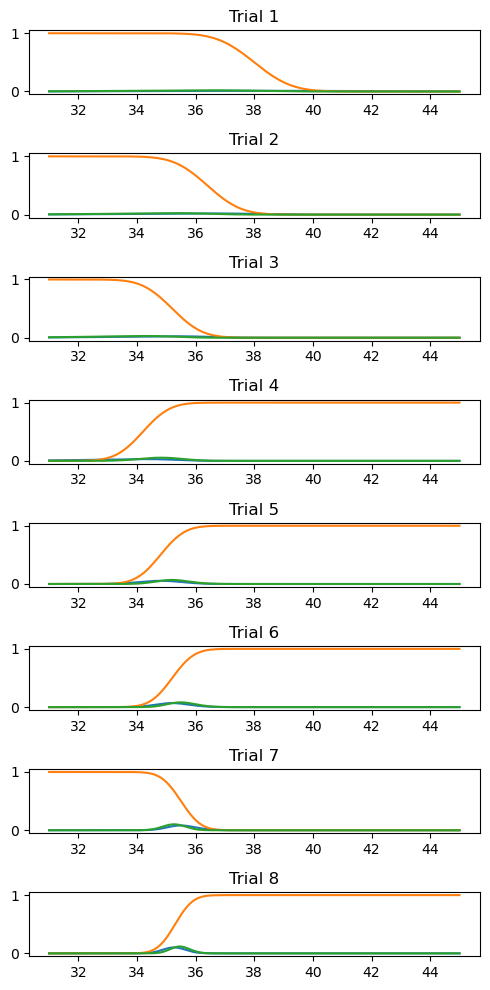

In [29]:
# One figure with all trials
fig, ax = plt.subplots(trials, 1, figsize=(5, 10))
for trial in range(trials):
    ax[trial].plot(x, priors[trial], label='Prior')
    ax[trial].plot(x, likelihoods[trial], label='Likelihood')
    ax[trial].plot(x, posteriors[trial], label='Posterior')
    ax[trial].set_title(f'Trial {trial+1}')
plt.tight_layout()
plt.show()